## Embedding Approach --> pipeline to train the model

In [25]:
! pip install clip
! pip install torch
! pip install torchvision
! pip install transformers


In [ ]:
import os

#### Images location --> change to the path you have your images stored in
catalog_images_location_folder = "/content/drive/MyDrive/Capstone Project/Data/Big basket Data_Images" ### big basket images directory

### this is where we  stored the pre-processed pkl file from the notebook 1_Pipeline_to_preprocess_catalog_data ...
path_to_load_the_preprocessed_df = "/content/drive/MyDrive/Capstone Project/Data/Big basket Data/preprocessed.csv" #### where to save the new processed data frame with the description embedding?

### this is where we want to save the embedding
loction_to_load_desc_embeddings = "/content/drive/MyDrive/Capstone Project/Data/Big basket Data/embedding.csv" #### where to load the description embedding?

#### This is the location where you want to save the category, sub-category and brand encoder-decoder
location_to_save_encoder = 'label_encoders.pkl' ### where to save the label encoder?? --> this is important for later --> when we want to get from the "encoded" category/brand the actual text-label

#### Locations where to save outputs from the model
log_file = "log_embedding_model.txt"
folder_to_save_embed_model = "Tier_approach_logs_performacne/embed_model"
location_to_save_embedding_model_performance_in_bucket = "Tier_approach_logs_performacne/performance_embed_model"
folder_to_save_products_embeddings = "Tier_approach_logs_performacne"




In [27]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import os
import torch
import clip
import datetime
from PIL import Image
from tqdm import tqdm

import zipfile
from io import BytesIO

import cv2
import seaborn as sns

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import models, transforms
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

import xml.etree.ElementTree as ET

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")
# device = "cpu"
DEVICE = device

try:
  ### Connect to my google drive
  from google.colab import drive
  drive.mount('/content/drive')
except:
  print("Could not connect to drive")


Using CPU
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reading the catalog - preprocessed data &  embeddings

In [28]:
#### logic to combine the embedding and the description-embedding table
df_preprocessed = pd.read_csv(path_to_load_the_preprocessed_df)
df_embeddings = pd.read_csv(loction_to_load_desc_embeddings)
df_embeddings = df_embeddings.dropna() ### drop embedding rows that have NAs

embedding_columns = df_embeddings.columns[2:] ### these are all the embedding columns

df_embeddings['Description_embedding'] = df_embeddings[embedding_columns].values.tolist()
### convert Description_embedding column to tensor
df_embeddings['Description_embedding'] = df_embeddings['Description_embedding'].apply(lambda x: torch.tensor(x, dtype=torch.float))

df = pd.merge(df_preprocessed, df_embeddings[['image_path','Description_embedding']], on = "image_path", how = "inner")

print(df.shape)
display(df.head())

(7786, 15)


,Unnamed: 0,masterCategory,subCategory,Sub_sub_Category,Product Link,EAN Code,Image Link,brand,SKU Name,SKU Size,MRP,Description,index,image_path,Description_embedding
0,0,beauty & hygiene,skin care,aromatherapy,https://www.bigbasket.com/pd/1221014/soulflowe...,1221014,https://www.bigbasket.com/media/uploads/p/l/12...,Soulflower,"Soulflower Cold Pressed Castor Oil, 2 x 225 ml...",2 x 225 ml,₹700,"100% pure, natural, vegan and cold-pressed Sou...",0,/content/drive/MyDrive/Capstone Project/Data/B...,"[tensor(-0.2207), tensor(0.1895), tensor(0.265..."
1,1,beauty & hygiene,skin care,aromatherapy,https://www.bigbasket.com/pd/40079159/soulflow...,40079159,https://www.bigbasket.com/media/uploads/p/l/40...,Soulflower,Soulflower Tea Tree Essential Oil - For Oily A...,30 ml,₹850,"100% pure, natural and vegan Soulflower Tea Tr...",1,/content/drive/MyDrive/Capstone Project/Data/B...,"[tensor(-0.2829), tensor(0.1599), tensor(0.284..."
2,2,beauty & hygiene,skin care,aromatherapy,https://www.bigbasket.com/pd/40324133/thriveco...,40324133,https://www.bigbasket.com/media/uploads/p/l/40...,ThriveCo,ThriveCo Rosemary Essential Oil - Boosts Hair ...,NaN,₹449,Rosemary oil stimulates blood circulation to t...,2,/content/drive/MyDrive/Capstone Project/Data/B...,"[tensor(0.0240), tensor(0.0846), tensor(0.3332..."
3,3,beauty & hygiene,skin care,aromatherapy,https://www.bigbasket.com/pd/40079161/soulflow...,8904134017519,https://www.bigbasket.com/media/uploads/p/l/40...,Soulflower,Soulflower Peppermint Essential Oil for Hair G...,NaN,₹450,"100% pure, natural and vegan Soulflower Pepper...",3,/content/drive/MyDrive/Capstone Project/Data/B...,"[tensor(-0.2843), tensor(0.1343), tensor(0.308..."
4,4,beauty & hygiene,skin care,aromatherapy,https://www.bigbasket.com/pd/1220833/soulflowe...,1220833,https://www.bigbasket.com/media/uploads/p/l/12...,Soulflower,Soulflower Cold Pressed Olive Oil - For Dry Sk...,2x120 ml,₹430,"Soul flower high-end olive oil will soothe, co...",4,/content/drive/MyDrive/Capstone Project/Data/B...,"[tensor(-0.0666), tensor(0.2017), tensor(0.369..."


In [29]:
### remove rows with NA value in column 'image_path'
num_rows_before = df.shape[0]
df.dropna(subset=['image_path'], inplace=True)

num_rows_after = df.shape[0]
rows_removed = num_rows_before - num_rows_after

print(f'Number of rows before: {num_rows_before}')
print(f'Number of rows removed: {rows_removed}')
print(f'Number of rows now: {df.shape[0]}')

Number of rows before: 7786
Number of rows removed: 0
Number of rows now: 7786


### Let's see an example for an image in the dataset

,56
Unnamed: 0,57
masterCategory,beauty & hygiene
subCategory,skin care
Sub_sub_Category,aromatherapy
Product Link,https://www.bigbasket.com/pd/40034182/organic-...
EAN Code,40034182
Image Link,https://www.bigbasket.com/media/uploads/p/l/40...
brand,Organic Harvest
SKU Name,"Organic Harvest Grapeseed Oil, 60 ml"
SKU Size,60 ml


array([[[ 76, 112,  71],
        [ 76, 112,  71],
        [ 76, 112,  71],
        ...,
        [ 76, 112,  71],
        [ 76, 112,  71],
        [ 76, 112,  71]],

       [[ 76, 112,  71],
        [ 76, 112,  71],
        [ 76, 112,  71],
        ...,
        [ 76, 112,  71],
        [ 76, 112,  71],
        [ 76, 112,  71]],

       [[ 76, 112,  71],
        [ 76, 112,  71],
        [ 76, 112,  71],
        ...,
        [ 76, 112,  71],
        [ 76, 112,  71],
        [ 76, 112,  71]],

       ...,

       [[ 76, 112,  71],
        [ 76, 112,  71],
        [ 76, 112,  71],
        ...,
        [ 76, 112,  71],
        [ 76, 112,  71],
        [ 76, 112,  71]],

       [[ 76, 112,  71],
        [ 76, 112,  71],
        [ 76, 112,  71],
        ...,
        [ 76, 112,  71],
        [ 76, 112,  71],
        [ 76, 112,  71]],

       [[ 76, 112,  71],
        [ 76, 112,  71],
        [ 76, 112,  71],
        ...,
        [ 76, 112,  71],
        [ 76, 112,  71],
        [ 76, 112,  71]]], dtype=uint8)
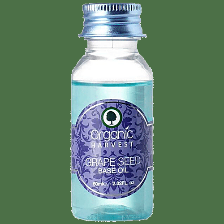

In [30]:
idx_to_display = 56
resize_image = True
display_image = True

a = df.iloc[idx_to_display]
display(a)

specific_image_path = a["image_path"]
image = Image.open(specific_image_path)

if display_image:
  image = Image.open(specific_image_path)
  if resize_image:
    import cv2
    im = cv2.imread(specific_image_path)
    im_resized = cv2.resize(im, (224, 224))
    display(im_resized)
  else:
    display(image)


## Define dataset

In [31]:
# Custom dataset class
class Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row['image_path']
        img = Image.open(img_path).convert("RGB")  # Load image in RGB mode

        if self.transform:
            img = self.transform(img)

        # Extract labels
        master_category = torch.tensor(row['masterCategory'], dtype=torch.long)
        sub_category = torch.tensor(row['subCategory'], dtype=torch.long)
        brand = torch.tensor(row['brand'], dtype=torch.long)

        description = torch.tensor(row['Description_embedding'], dtype = torch.float)

        # Convert description embedding from string to float tensor
        # description = [float(val) for val in row['Description_embedding'].split(' ')]  # Convert to list of floats
        # description = torch.tensor(description, dtype=torch.float)

        return img, master_category, sub_category, brand, description

### Remove brands that appear only once in the dataset, so then we can stratify accoridng to brand

In [32]:
import pandas as pd

# Assuming 'df' is your DataFrame and 'brand' is the column name
brand_counts = df['brand'].value_counts()

# Filter to keep only brands that appear more than once
brands_to_keep = brand_counts[brand_counts > 1].index

# Filter the original DataFrame to keep only those brands
df = df[df['brand'].isin(brands_to_keep)]

# Calculate the number of rows removed
rows_removed = len(df) - len(df)

# Display the number of rows removed
print(f"Number of rows removed: {rows_removed}")


Number of rows removed: 0


In [33]:
num_categories = len(df["masterCategory"].unique())
num_subCategory = len(df["subCategory"].unique())
num_brand = len(df["brand"].unique())

print(f"Number of categories: {num_categories}")
print(f"Number of sub categories: {num_subCategory}")
print(f"Number of brands: {num_brand}")
print(f"Number of rows in the dataset: {df.shape[0]}")

Number of categories: 1
Number of sub categories: 8
Number of brands: 412
Number of rows in the dataset: 7670


### Define encoder

In [34]:
# Define the image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
# DEVICE = "cpu"
device = DEVICE

# Encode labels for masterCategory, subCategory, and brand
label_encoders = {}
for col in ['masterCategory', 'subCategory', 'brand']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Transform for image preprocessing
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ResNet normalization
])

### save the label encoder
import pickle

# Save label encoders to a pickle file
with open(location_to_save_encoder, 'wb') as f:
    pickle.dump(label_encoders, f)

# # Load label encoders from a pickle file
# with open('location_to_save_encoder.pkl', 'rb') as f:
#     label_encoders = pickle.load(f)

<ipython-input-34-7eccca53fda8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
<ipython-input-34-7eccca53fda8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
<ipython-input-34-7eccca53fda8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [35]:

dataset = Dataset(df, transform=transform)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

train_ratio = 0.8
test_ratio = 0.2

try:
  ### trying to split train-test and keep the "brand" distribution equal in train-test
  train_df, test_df = train_test_split(df, test_size=test_ratio, stratify=df['brand'])
  print("1 -> split train-test and keep the brand distribution equal in train-test")

except:
  try:
      ### trying to split train-test and keep the "subCategory" distribution equal in train-test
      train_df, test_df = train_test_split(df, test_size=test_ratio, stratify=df['subCategory'])
      print("2 -> split train-test and keep the subCategory distribution equal in train-test")

  except:
    try:
        ### trying to split train-test and keep the "masterCategory" distribution equal in train-test
        train_df, test_df = train_test_split(df, test_size=test_ratio, stratify=df['masterCategory'])
        print("3 -> split train-test and keep the masterCategory distribution equal in train-test")
    except:
        train_df, test_df = train_test_split(df, test_size=test_ratio)
        print("4 -> split train-test")

# TODO: why different number of unique brands?
print('unique brands in train set: ', len(train_df['brand'].unique()))
print('unique brands in test set: ', len(test_df['brand'].unique()))
print()
print('unique subCategory in train set: ', len(train_df['subCategory'].unique()))
print('unique subCategory in test set: ', len(test_df['subCategory'].unique()))
print()
print('unique masterCategory in train set: ', len(train_df['masterCategory'].unique()))
print('unique masterCategory in test set: ', len(test_df['masterCategory'].unique()))


train_dataset = Dataset(train_df, transform=transform)
test_dataset = Dataset(test_df, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


# Optionally, you can check the sizes of the datasets
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

1 -> split train-test and keep the brand distribution equal in train-test
unique brands in train set:  412
unique brands in test set:  351

unique subCategory in train set:  8
unique subCategory in test set:  6

unique masterCategory in train set:  1
unique masterCategory in test set:  1
Train dataset size: 6136
Test dataset size: 1534


#### Example of one batch

In [36]:
for img, master_category, sub_category, brand, description_embedding in dataloader:
  print("success")
  break

print("img.shape:", img.shape)
print("len(master_category):", len(master_category))
print("brand:", brand)

print("description_embedding:", description_embedding)
print("description_embedding shape:", description_embedding.shape)

<ipython-input-31-1116991f2b18>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  description = torch.tensor(row['Description_embedding'], dtype = torch.float)
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


success
img.shape: torch.Size([64, 3, 224, 224])
len(master_category): 64
brand: tensor([251, 365,  83, 285,  83, 125,  60, 248, 361, 167, 285, 217,  18, 394,
         97, 185, 330, 106, 106, 408, 112, 393, 285, 348, 369, 330,  94, 116,
        186, 352, 217,  81, 190, 240, 115, 224, 252, 206, 275, 233, 154,  67,
        248, 265, 160, 142,  83, 141, 116, 314, 280,  80,  83, 310,  77, 173,
        257,  26, 224, 160, 324,  26, 271, 292])
description_embedding: tensor([[-0.1929,  0.0341,  0.2844,  ..., -0.1556, -0.1674, -0.0151],
        [-0.2647,  0.0425,  0.1987,  ..., -0.1201, -0.2254,  0.2766],
        [ 0.0616, -0.0354,  0.4700,  ..., -0.1043,  0.0262, -0.0402],
        ...,
        [-0.1297, -0.2143,  0.4956,  ..., -0.2424, -0.1948, -0.0182],
        [-0.2404,  0.1766,  0.3495,  ...,  0.0397, -0.1276,  0.0674],
        [-0.1649,  0.0052,  0.1277,  ..., -0.0971, -0.2554,  0.0062]])
description_embedding shape: torch.Size([64, 768])


### Model Definition for Embedding Generation

Next we define a model that will output embeddings.

We will use a pretrained CNN like ResNet for image feature extraction and adjust the output layer to produce embeddings.

+ `num_master`: The number of unique master categories in the dataset.
+ `num_sub`: The number of unique subcategories in the dataset.
+ `num_brand`: The number of unique brands in the dataset.
+ `dim_embed_image`: Size of the image embedding (set to 1000 in the example).
+ `dim_embed_description`: Size of the precomputed description embedding (e.g., from a BERT model).
+ `required_dim_embed_description`: The size to which the description embeddings will be projected.
+ `self.dim_embed`: The total combined size of the image and description embeddings, which is passed to the classification heads.


### Embedding dim logic
We have an argument: `dim_embed`. The logic:
We have image embedding shape and description embedding shape.
The `MultiTaskResNet` creates the embedding for a given image, but it can also gets as input embedding of the description of the product.

If the class gets as input als othe embedding of the product then:
The embedding of the image will be: dim_embed
The final embedding of the product will be: dim_embed + the dim_embed_description



In [37]:
### Moreb back-bone ResNet options:
#self.backbone = models.resnet18(pretrained=True)
#self.backbone = models.resnet34(pretrained=True)
#self.image_embedding = nn.Linear(512, dim_embed_image)  # ResNet18 and ResNet34 outputs 512-dim features


#self.backbone = models.resnet50(pretrained=True)
#self.backbone = models.resnet101(pretrained=True)
#self.backbone = models.resnet152(pretrained=True)
#self.image_embedding = nn.Linear(2048, dim_embed_image) # ResNet50 and ResNet101 and ResNet152 outputs 2048-dim features

In [38]:
import torch
import torch.nn as nn
import torchvision.models as models

class MultiTaskResNet2(nn.Module):
    def __init__(self, num_master, num_sub, num_brand, dim_embed_image=1000, dim_embed_description=768, required_dim_embed_description = 768):
        super(MultiTaskResNet2, self).__init__()

        self.required_dim_embed_description = required_dim_embed_description
        ### Define the embedding size
        self.dim_embed_image = dim_embed_image  # The required embedding size for a given image
        self.dim_embed_description = dim_embed_description  # The embedding size of the description (e.g., 768 for BERT/DistilBERT)
        self.dim_embed = self.dim_embed_image + self.required_dim_embed_description  # The final embedding is the sum of image and description embeddings

        # Load pre-trained ResNet18
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the final fully connected layer

        # Flattening layer
        self.flatten = nn.Flatten()

        # Image embedding layer
        self.image_embedding = nn.Linear(512, dim_embed_image)  # ResNet18 outputs 512-dim features, map to the desired size

        # Linear layer for description embedding (to learn which parts of the description are important)
        self.description_embedding_layer = nn.Linear(dim_embed_description, required_dim_embed_description)  # take the dim of the input description embedding and send it to required_dim_embed_description
        self.relu = nn.ReLU()

        # Classification heads
        self.master_head = nn.Linear(self.dim_embed, num_master)
        self.sub_head = nn.Linear(self.dim_embed, num_sub)
        self.brand_head = nn.Linear(self.dim_embed, num_brand)

    def forward(self, x, embedding_desc=None):
        """
        x: Image input (batch_size, 3, H, W)
        embedding_desc: Precomputed description embeddings (batch_size, dim_embed_description)
        """

        # Process image through ResNet
        x = self.backbone(x)
        x = self.flatten(x)  # Flatten the output to (batch_size, 512)

        # Compute image embedding
        x_embedding = self.image_embedding(x)  # (batch_size, dim_embed_image)

        # Process description embedding
        if embedding_desc is not None:
            desc_embedding = self.description_embedding_layer(embedding_desc)  # (batch_size, required_dim_embed_description)
            desc_embedding = self.relu(desc_embedding)  # Apply ReLU activation
        else:
            # If no description embedding is provided, use a zero tensor of the same shape
            desc_embedding = torch.zeros((x.shape[0], self.required_dim_embed_description), device=x.device)

        # Concatenate image and description embeddings
        combined_embedding = torch.cat((x_embedding, desc_embedding), dim=1)  # (batch_size, dim_embed)

        # Classification outputs
        master_output = self.master_head(combined_embedding)
        sub_output = self.sub_head(combined_embedding)
        brand_output = self.brand_head(combined_embedding)

        return combined_embedding, master_output, sub_output, brand_output


# Example usage:
num_master = len(df['masterCategory'].unique())
num_sub = len(df['subCategory'].unique())
num_brand = len(df['brand'].unique())
dim_embed_description = df["Description_embedding"][0].shape[0]
required_dim_embed_description = 768
dim_embed_image = 1000

model = MultiTaskResNet2(num_master, num_sub, num_brand, dim_embed_image=dim_embed_image,
                         dim_embed_description=dim_embed_description,
                         required_dim_embed_description = required_dim_embed_description).to(DEVICE)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s]


In [40]:
number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of params:{round(number_params/1000000,3)}M")


Number of params:13.025M


In [41]:
# Example input
images = torch.randn(BATCH_SIZE, 3, 224, 224).to(DEVICE)  # Example batch of images
descriptions_embed = torch.randn(BATCH_SIZE, dim_embed_description).to(DEVICE)

# Forward pass
embeddings, master_output, sub_output, brand_output = model(images, descriptions_embed)

# Check shapes
print("Embeddings shape:", embeddings.shape)  # Should be (batch_size, 1000)
print("Master Output shape:", master_output.shape)  # Should be (batch_size, num_master)
print("Sub Output shape:", sub_output.shape)  # Should be (batch_size, num_sub)
print("Brand Output shape:", brand_output.shape)  # Should be (batch_size, num_brand)

Embeddings shape: torch.Size([64, 1768])
Master Output shape: torch.Size([64, 1])
Sub Output shape: torch.Size([64, 8])
Brand Output shape: torch.Size([64, 412])


### Step 4: Define Loss Function and Optimizer
We’ll use CrossEntropyLoss for each task and Adam optimizer.

In [42]:
# Define loss functions and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [43]:
from tqdm import tqdm
j = 0
for images, master_labels, sub_labels, brand_labels, description_embedding in tqdm(dataloader):
    images, master_labels = images.to(device), master_labels.to(device)
    sub_labels, brand_labels = sub_labels.to(device), brand_labels.to(device)
    description_embedding.to(device)
    j +=1
    if j ==3:
        break

  0%|          | 0/120 [00:00<?, ?it/s]<ipython-input-31-1116991f2b18>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  description = torch.tensor(row['Description_embedding'], dtype = torch.float)
  2%|▏         | 2/120 [01:22<1:21:24, 41.39s/it]


In [44]:
embedding, master_output, sub_output, brand_output = model(images)
loss_master = criterion(master_output, master_labels)
loss_sub = criterion(sub_output, sub_labels)
loss_brand = criterion(brand_output, brand_labels)

# Check shapes
print("Embeddings shape:", embeddings.shape)  # Should be (batch_size, 1000)
print("Master Output shape:", master_output.shape)  # Should be (batch_size, num_master)
print("Sub Output shape:", sub_output.shape)  # Should be (batch_size, num_sub)
print("Brand Output shape:", brand_output.shape)  # Should be (batch_size, num_brand)


Embeddings shape: torch.Size([64, 1768])
Master Output shape: torch.Size([64, 1])
Sub Output shape: torch.Size([64, 8])
Brand Output shape: torch.Size([64, 412])


## Training loop for the embedding model

In [46]:
import datetime

def train(model, dataloader, criterion, optimizer, epochs=5, save_logs_after_k_batches = 100, log_file = None, dir_save_model = None):

    model.train()

    # list_avg_loss_all = []
    # list_avg_loss_category = []
    # list_avg_loss_sub_category = []
    # list_avg_loss_brand = []

    for epoch in range(epochs):
        running_loss = 0.0
        count = 0
        running_loss_master = 0.0
        running_loss_sub = 0.0
        running_loss_brand = 0.0
        list_avg_loss_all = []
        list_avg_loss_category = []
        list_avg_loss_sub_category = []
        list_avg_loss_brand = []
        progress_bar2 = tqdm(total=len(dataloader), desc="Training Iterations", unit="iter")

        for images, master_labels, sub_labels, brand_labels, description_embedding in dataloader:
            images, master_labels = images.to(device), master_labels.to(device)
            sub_labels, brand_labels = sub_labels.to(device), brand_labels.to(device)
            description_embedding = description_embedding.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            embedding, master_output, sub_output, brand_output = model(images, description_embedding)

            # Calculate losses for each task
            loss_master = criterion(master_output, master_labels)
            loss_sub = criterion(sub_output, sub_labels)
            loss_brand = criterion(brand_output, brand_labels)

            # Total loss (can adjust weights if needed)
            loss = loss_master + loss_sub + loss_brand

            # Accumulate losses
            running_loss += loss.item()
            running_loss_master += loss_master.item()
            running_loss_sub += loss_sub.item()
            running_loss_brand += loss_brand.item()
            count += 1

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate average losses
            avg_loss = running_loss / count
            avg_loss_category = running_loss_master / count
            avg_loss_sub_category = running_loss_sub / count
            avg_loss_brand = running_loss_brand / count

            # Update the iteration progress bar
            progress_bar2.set_postfix({
                "Avg loss": f"{avg_loss:.4f}",
                "Avg category loss": f"{avg_loss_category:.4f}",
                "Avg sub category loss": f"{avg_loss_sub_category:.4f}",
                "Avg brand loss": f"{avg_loss_brand:.4f}"
            })
            progress_bar2.update(1)

            list_avg_loss_all.append(running_loss / count)
            list_avg_loss_category.append(running_loss_master / count)
            list_avg_loss_sub_category.append(running_loss_sub / count)
            list_avg_loss_brand.append(running_loss_brand / count)

            log_message = (
              f"Avg loss: {avg_loss:.4f}, "
              f"Avg category loss: {avg_loss_category:.4f}, "
              f"Avg sub category loss: {avg_loss_sub_category:.4f}, "
              f"Avg brand loss: {avg_loss_brand:.4f}")

            if (count % save_logs_after_k_batches == 0) | (count == 1) or (count == len(train_loader)):  # Write logs every k batches
                if log_file:
                    if log_file.endswith(".txt"):  # Ensure it's a text file
                        with open(log_file, "a") as f:  # Open in append mode
                            if count == 1:
                              current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                              f.write("--------------------------------------------------------------------------------------------------------------------------------------------------------")
                              f.write(f"Logging started at: {current_time}\n") ##### write the time and date of now

                            f.write(log_message + "\n")
                    else:
                        print("Warning: Provided file is not a .txt file, skipping logging.")

                # Save the model periodically
                if dir_save_model:
                    # Ensure the directory exists
                    if not os.path.exists(dir_save_model):
                        os.makedirs(dir_save_model)

                    model_save_path = f"{dir_save_model}/model_epoch_{epoch + 1}_batch_{count}.pth"
                    torch.save(model.state_dict(), model_save_path)
                    #print(f"Model saved to {model_save_path}")


        # list_avg_loss_all.append(running_loss / count)
        # list_avg_loss_category.append(running_loss_master / count)
        # list_avg_loss_sub_category.append(running_loss_sub / count)
        # list_avg_loss_brand.append(running_loss_brand / count)

    return list_avg_loss_all, list_avg_loss_category, list_avg_loss_sub_category, list_avg_loss_brand



In [ ]:
# Train the model
from tqdm import tqdm
epochs = 1
list_avg_loss_all, list_avg_loss_category, list_avg_loss_sub_category, list_avg_loss_brand = train(model, train_loader, criterion, optimizer, epochs=epochs,
                                                                                                   save_logs_after_k_batches = 200,
                                                                                                   log_file = log_file, #"log_file.txt",
                                                                                                   dir_save_model = folder_to_save_embed_model)


Training Iterations:   0%|          | 0/96 [00:00<?, ?iter/s]<ipython-input-31-1116991f2b18>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  description = torch.tensor(row['Description_embedding'], dtype = torch.float)


## Save model metrics/embeddings

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


def save_model_metrics(model, dataloader, device, list_avg_loss_all, list_avg_loss_category, list_avg_loss_sub_category, list_avg_loss_brand, title=None):

    current_time = datetime.datetime.now().strftime("%Y-%m-%d_%I-%M_%p")
    save_path = f"{title}_metrics_{current_time}"
    os.makedirs(save_path, exist_ok=True)
    file_name = os.path.join(save_path, f"{title}_model_{current_time}.pth")

    torch.save(model, file_name)

    def plot_confusion_matrix(y_true, y_pred, title, save_path):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
        plt.title(f'Confusion Matrix - {title}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(os.path.join(save_path, f'{title}_confusion_matrix.png'))
        plt.close()

    print('generating loss plot')
    plt.figure(figsize=(12, 6))
    plt.plot(list_avg_loss_all, label='Average Loss', marker='o')
    plt.plot(list_avg_loss_category, label='Average Category Loss', marker='o')
    plt.plot(list_avg_loss_sub_category, label='Average Sub Category Loss', marker='o')
    plt.plot(list_avg_loss_brand, label='Average Brand Loss', marker='o')
    plt.title('Training Losses over Epochs')
    plt.xlabel('Training iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(save_path, 'training_losses.png'))
    plt.close()


    model.eval()  # Set the model to evaluation mode
    all_master_preds, all_sub_preds, all_brand_preds = [], [], []
    all_master_labels, all_sub_labels, all_brand_labels = [], [], []
    all_embeddings = []

    print('getting predictions from model...')
    with torch.no_grad():  # No need to calculate gradients
        for images, master_labels, sub_labels, brand_labels, description_embedding in dataloader:
            images = images.to(device)
            master_labels = master_labels.to(device)
            sub_labels = sub_labels.to(device)
            brand_labels = brand_labels.to(device)
            description_embedding = description_embedding.to(device)

            # Get the model's predictions and embeddings
            embeddings, master_outputs, sub_outputs, brand_outputs = model(images, description_embedding)

            # Store embeddings
            all_embeddings.extend(embeddings.cpu().numpy())  # Convert to numpy and extend the list

            # Get the predicted class indices
            master_preds = torch.argmax(master_outputs, dim=1).cpu().numpy()
            sub_preds = torch.argmax(sub_outputs, dim=1).cpu().numpy()
            brand_preds = torch.argmax(brand_outputs, dim=1).cpu().numpy()

            # Store predictions and labels
            all_master_preds.extend(master_preds)
            all_sub_preds.extend(sub_preds)
            all_brand_preds.extend(brand_preds)
            all_master_labels.extend(master_labels.cpu().numpy())
            all_sub_labels.extend(sub_labels.cpu().numpy())
            all_brand_labels.extend(brand_labels.cpu().numpy())

    # Convert lists to numpy arrays for metric calculations
    all_master_preds = np.array(all_master_preds)
    all_sub_preds = np.array(all_sub_preds)
    all_brand_preds = np.array(all_brand_preds)
    all_master_labels = np.array(all_master_labels)
    all_sub_labels = np.array(all_sub_labels)
    all_brand_labels = np.array(all_brand_labels)
    all_embeddings = np.array(all_embeddings)  # Convert embeddings to numpy array

    # Save the embeddings to a pickle file
    with open(os.path.join(save_path, 'embeddings.pkl'), 'wb') as f:
        pickle.dump(all_embeddings, f)

    print('Embeddings saved to embeddings.pkl')

    print('generating master category report')
    master_report = classification_report(all_master_labels, all_master_preds)
    print('generating sub category report')
    sub_report = classification_report(all_sub_labels, all_sub_preds)
    print('generating brand report')
    brand_report = classification_report(all_brand_labels, all_brand_preds)

    with open(os.path.join(save_path, 'classification_reports.txt'), 'w') as f:
        f.write("Master Category Evaluation:\n")
        f.write(master_report)
        f.write("\nSub Category Evaluation:\n")
        f.write(sub_report)
        f.write("\nBrand Evaluation:\n")
        f.write(brand_report)

    # Confusion Matrices
    print('generating master category confusion matrix')
    plot_confusion_matrix(all_master_labels, all_master_preds, "Master Category", save_path)
    print('generating sub category confusion matrix')
    plot_confusion_matrix(all_sub_labels, all_sub_preds, "Sub Category", save_path)
    # print('generating brand confusion matrix')
    # plot_confusion_matrix(all_brand_labels, all_brand_preds, "Brand", save_path)




In [ ]:
save_model_metrics(model, test_loader, DEVICE, list_avg_loss_all, list_avg_loss_category, list_avg_loss_sub_category, list_avg_loss_brand, 'catalog_data')

generating loss plot
getting predictions from model...
Embeddings saved to embeddings.pkl
generating master category report
generating sub category report
generating brand report


c:\Users\Austin\anaconda3\envs\condaenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Austin\anaconda3\envs\condaenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Austin\anaconda3\envs\condaenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

generating master category confusion matrix
generating sub category confusion matrix


In [ ]:
def save_embeddings(model, dataloader, filename = None):
    # Initialize lists to store embeddings and labels
    all_embeddings = []
    all_master_labels = []
    all_sub_labels = []
    all_brand_labels = []
    filename = filename + '_' if filename else ''

    model.eval()
    print('generating embeddings from provided dataloader')
    # Loop through all batches in the test_loader
    with torch.no_grad():  # Disable gradient calculation
        for images, master_labels, sub_labels, brand_labels, description_embed in tqdm(dataloader):
            images, master_labels = images.to(device), master_labels.to(device)
            sub_labels, brand_labels = sub_labels.to(device), brand_labels.to(device)
            description_embed = description_embed.to(device)

            embeddings, master_outputs, sub_outputs, brand_outputs  = model(images, description_embed)

            # Append the embeddings and labels to the lists
            all_embeddings.append(embeddings.cpu())  # Move to CPU for easier handling
            all_master_labels.append(master_labels.cpu())
            all_sub_labels.append(sub_labels.cpu())
            all_brand_labels.append(brand_labels.cpu())

    # Concatenate all the embeddings and labels into single tensors
    all_embeddings = torch.cat(all_embeddings, dim=0)
    all_master_labels = torch.cat(all_master_labels, dim=0)
    all_sub_labels = torch.cat(all_sub_labels, dim=0)
    all_brand_labels = torch.cat(all_brand_labels, dim=0)

    print('embeddings shape: ', all_embeddings.shape)

    # Save embeddings and labels to a file
    file_name = f'{filename}embeddings.pkl'
    with open(file_name, 'wb') as f:
        pickle.dump({
            'embeddings': all_embeddings,
            'master_labels': all_master_labels,
            'sub_labels': all_sub_labels,
            'brand_labels': all_brand_labels
        }, f)

    print(f"Embeddings saved to {file_name}")



generating embeddings from provided dataloader


  0%|          | 0/343 [00:00<?, ?it/s]c:\Users\Austin\anaconda3\envs\condaenv\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 343/343 [12:49<00:00,  2.24s/it]


embeddings shape:  torch.Size([21919, 1768])
Embeddings saved to big_basket_test_embeddings.pkl


In [ ]:
print("saving the train set embeddings")
save_embeddings(model, train_loader, filename = os.path.join(folder_to_save_products_embeddings, 'train_set_'))


In [ ]:

print("saving the test set embeddings")
save_embeddings(model, test_loader, filename = os.path.join(folder_to_save_products_embeddings, 'test_set_'))


'dad/embedding_train_set'

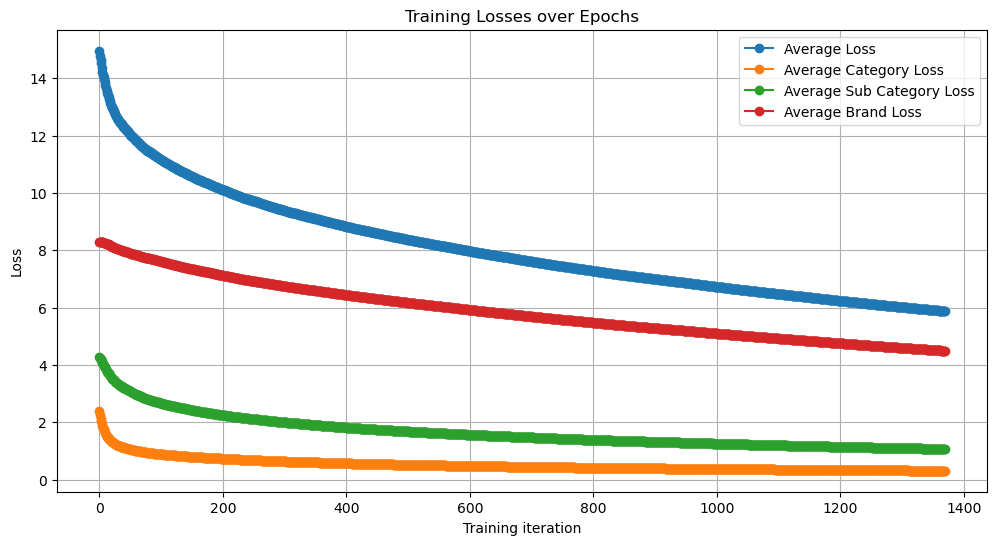

In [ ]:
# Plotting the losses
plt.figure(figsize=(12, 6))
plt.plot(list_avg_loss_all, label='Average Loss', marker='o')
plt.plot(list_avg_loss_category, label='Average Category Loss', marker='o')
plt.plot(list_avg_loss_sub_category, label='Average Sub Category Loss', marker='o')
plt.plot(list_avg_loss_brand, label='Average Brand Loss', marker='o')
plt.title('Training Losses over Epochs')
plt.xlabel('Training iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## Performance

In [ ]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_master_preds, all_sub_preds, all_brand_preds = [], [], []
    all_master_labels, all_sub_labels, all_brand_labels = [], [], []

    with torch.no_grad():  # No need to calculate gradients
        for images, master_labels, sub_labels, brand_labels in dataloader:
            images = images.to(device)
            master_labels = master_labels.to(device)
            sub_labels = sub_labels.to(device)
            brand_labels = brand_labels.to(device)

            # Get the model's predictions
            embeddings, master_outputs, sub_outputs, brand_outputs = model(images)

            # Get the predicted class indices
            master_preds = torch.argmax(master_outputs, dim=1).cpu().numpy()
            sub_preds = torch.argmax(sub_outputs, dim=1).cpu().numpy()
            brand_preds = torch.argmax(brand_outputs, dim=1).cpu().numpy()

            # Store predictions and labels
            all_master_preds.extend(master_preds)
            all_sub_preds.extend(sub_preds)
            all_brand_preds.extend(brand_preds)
            all_master_labels.extend(master_labels.cpu().numpy())
            all_sub_labels.extend(sub_labels.cpu().numpy())
            all_brand_labels.extend(brand_labels.cpu().numpy())

    # Convert lists to numpy arrays for metric calculations
    all_master_preds = np.array(all_master_preds)
    all_sub_preds = np.array(all_sub_preds)
    all_brand_preds = np.array(all_brand_preds)
    all_master_labels = np.array(all_master_labels)
    all_sub_labels = np.array(all_sub_labels)
    all_brand_labels = np.array(all_brand_labels)

    # Calculate metrics
    print("Master Category Evaluation:")
    print(classification_report(all_master_labels, all_master_preds))

    print("Sub Category Evaluation:")
    print(classification_report(all_sub_labels, all_sub_preds))

    print("Brand Evaluation:")
    print(classification_report(all_brand_labels, all_brand_preds))

    # Confusion Matrices
    plot_confusion_matrix(all_master_labels, all_master_preds, "Master Category")
    plot_confusion_matrix(all_sub_labels, all_sub_preds, "Sub Category")
  #   plot_confusion_matrix(all_brand_labels, all_brand_preds, "Brand")

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


## Evaluate test

### Evaluate specific image results

Button(description='Shuffle Image', style=ButtonStyle())

index image in df:12642


c:\Users\Austin\anaconda3\envs\condaenv\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


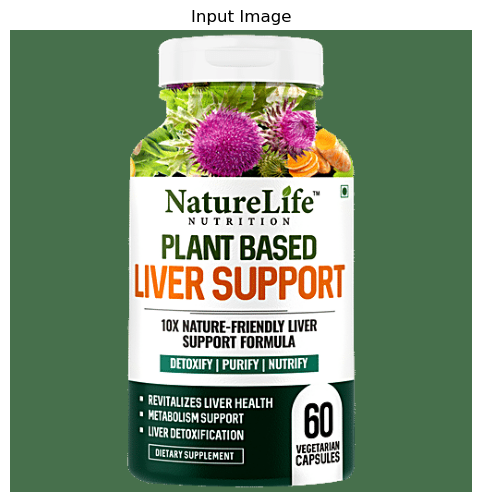

,Category,Sub Category,Brand
Prediction,beauty & hygiene,health & medicine,Nature Life Nutrition
True,beauty & hygiene,health & medicine,Nature Life Nutrition


In [ ]:
import torch
import pandas as pd
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Function to predict and compare
def predict_and_compare(model, df, index, device, label_encoders):
    print(f"index image in df:{index}")
    # Ensure the index is valid
    if index < 0 or index >= len(df):
        raise IndexError("Index is out of bounds for the DataFrame.")

    # Retrieve the relevant data from the DataFrame
    image_path = df.iloc[index]['image_path']
    original_master = df.iloc[index]['masterCategory']
    original_sub = df.iloc[index]['subCategory']
    original_brand = df.iloc[index]['brand']

    # Define the transformations (adjust according to your training transformations)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match the model input size
        transforms.ToTensor(),           # Convert the image to a tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
    ])

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')  # Ensure image is RGB
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Set the model to evaluation mode and make predictions
    model.eval()
    with torch.no_grad():
        embeddings, master_output, sub_output, brand_output = model(image_tensor)

        # Get the predicted classes
        master_pred = torch.argmax(master_output, dim=1).item()
        sub_pred = torch.argmax(sub_output, dim=1).item()
        brand_pred = torch.argmax(brand_output, dim=1).item()

    # Inverse transform using the label encoders
    original_master = label_encoders['masterCategory'].inverse_transform([original_master])[0]
    master_pred = label_encoders['masterCategory'].inverse_transform([master_pred])[0]

    original_sub = label_encoders['subCategory'].inverse_transform([original_sub])[0]
    sub_pred = label_encoders['subCategory'].inverse_transform([sub_pred])[0]

    original_brand = label_encoders['brand'].inverse_transform([original_brand])[0]
    brand_pred = label_encoders['brand'].inverse_transform([brand_pred])[0]

    # Prepare a comparison table
    comparison = {
        'Category': [master_pred, original_master],
        'Sub Category': [sub_pred, original_sub],
        'Brand': [brand_pred, original_brand]
    }

    # Convert to DataFrame for better visualization
    comparison_df = pd.DataFrame(comparison, index=['Prediction', 'True'])

    # Plot the image
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')  # Hide axis
    plt.title("Input Image")
    plt.show()

    return comparison_df

# Shuffle function
def shuffle_and_display(model, df, device, label_encoders):
    index = torch.randint(0, len(df), (1,)).item()  # Random index

    # Clear previous output
    clear_output(wait=True)

    # Display the button again
    display(shuffle_button)

    # Make prediction and display results
    comparison_df = predict_and_compare(model, df, index, device, label_encoders)
    display(comparison_df)

# Create the shuffle button
shuffle_button = widgets.Button(description="Shuffle Image")
shuffle_button.on_click(lambda b: shuffle_and_display(model, df, DEVICE, label_encoders))  # Trigger shuffle_and_display on click

# Display the button and initial output
display(shuffle_button)
shuffle_and_display(model, df, DEVICE, label_encoders)
